## Задача 6. Компьютерное зрение: задача сегментации

Ершов Александр Сергеевич, гр. 22.М04-мм

Задача:


- [x] Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.
- [x] Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.
- [x] Попробовать улучшить качество изменяя архитектуру.
- [ ] \* (**+2 балла**) Сделать train/test разбиение. Внутри train сделать 5fold, обучить 5 моделей. Построить кривые обучения для каждого фолда. Предсказать тест со всех 5 моделей и сагрегировать предсказания (до расчета метрик), сравнить с одной моделью обученной на всех данных. Сравнить с моделями обученными на фолдах. Сравнить плохие предсказания теста на разных фолдах. Ошибается на одних и тех же семплах или на разных?
- [ ] \* (**+3 балла**) Сделать unet с pretrained энкодером (можно взять vgg или resnet18/34), сравнить с предыдущими пунктами.

-------

### Сделать train/test split (или кросс-валидацию), зафиксировать все сиды чтобы более-менее воспроизводились результаты. Добавить метрику **jaccard index**. Переобучиться на одном батче (например 4 картинки), попробовать получить почти идеальное качество, посмотреть получилось или нет. Посчитать метрики для батча и для теста. Обучить на всем train, построить train/val кривые для loss и для **jaccard index**, подобрать оптимальное время обучения (количество шагов) для фиксированных параметров. Визуализировать topN самых плохих предсказаний.

In [38]:
import random
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import torch
%precision %.5f
import warnings
warnings.filterwarnings('ignore')

In [39]:
def set_seed():
    random.seed(19)
    torch.manual_seed(19)

In [40]:
set_seed()

Подготовка датасета.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!unzip "drive/MyDrive/dataset.zip"

In [43]:
from glob import glob

IMAGES_FOLDER_PATH = "./dataset/images"

imgs_list = glob(f"{IMAGES_FOLDER_PATH}/*")
print(f"Images list length: {len(imgs_list)}")

Images list length: 2000


Класс для хранения датасета.

In [44]:
from torch.utils.data import Dataset
import numpy as np
import torch
import torchvision
from torchvision import io
import cv2

class MHD_Dataset(Dataset):
    def __init__(self, imgs_list, transform = lambda id: id):
        self.imgs = imgs_list
        self.transform = transform

    def __len__(self):
        return len(self.imgs)

    def get_mask_path(self, img_path):
        mask_path = img_path.split("/")
        mask_path[-2] = mask_path[-2].replace("images", "masks")
        mask_path[-1] = mask_path[-1][:-4] + ".png"
        mask_path = "/".join(mask_path)
        return mask_path

    def resize_image(self, img):
        return torchvision.transforms.Resize((256, 256))(img)

    def __getitem__(self, idx):
        img_path = self.imgs[idx]
        img = self.resize_image(io.read_image(img_path))
        img = self.transform(img / 255)
        
        mask_path = self.get_mask_path(img_path)
        mask = self.resize_image(io.read_image(mask_path))
        mask = self.transform(mask / 255)

        return img, mask

Разделение датасета на train и test.

In [45]:
train_dataset = MHD_Dataset(imgs_list[:-250])
test_dataset = MHD_Dataset(imgs_list[-250:])

print(f"Train dataset length: {len(train_dataset)}")
print(f"Test dataset length: {len(test_dataset)}")

Train dataset length: 1750
Test dataset length: 250


Посмотрим пример элемента датасета.

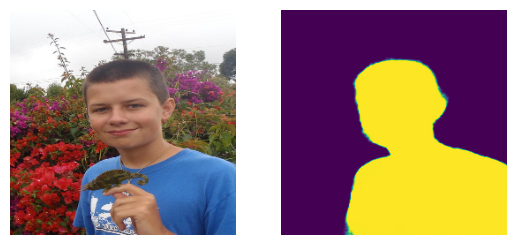

In [46]:
from torchvision.transforms import functional

def show_image_mask(image, mask):
    _, (ax_l, ax_r) = plt.subplots(ncols=2)
    ax_l.imshow(functional.to_pil_image(image))
    ax_l.axis("off")
    ax_r.imshow(functional.to_pil_image(mask))
    ax_r.axis("off")

image, mask = train_dataset[19]
show_image_mask(image, mask)

Добавим метрику jaccard index.

In [ ]:
!pip install torchmetrics
import torchmetrics

jaccard = torchmetrics.JaccardIndex(task="binary")

def compute_jaccard_metric(y_pred, y_true):
    return jaccard(y_pred.cpu(), y_true.cpu() > jaccard.threshold)

Реализация U-Net с пары.

In [48]:
from torch import nn

class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock, self).__init__()

        self.seq_block = nn.Sequential(nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
                                       nn.BatchNorm2d(out_channels),
                                       nn.ReLU(inplace=True))

    def forward(self, x):
        return self.seq_block(x)

class CNNBlocks(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
          super(CNNBlocks, self).__init__()

          self.layers = nn.ModuleList()
          for i in range(n_conv):
              self.layers.append(CNNBlock(in_channels, out_channels, padding=padding))
              in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

class Encoder(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder, self).__init__()

        self.enc_layers = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers += [CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding),
                                nn.MaxPool2d(2, 2)]

            in_channels = out_channels
            out_channels = 2 * out_channels

        self.enc_layers.append(CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))

    def forward(self, x):
        connections = []
        for layer in self.enc_layers:
            if isinstance(layer, CNNBlocks):
                x = layer(x)
                connections.append(x)
            else:
                x = layer(x)
        return x, connections

class Decoder(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()

        for i in range(n_up):
            self.layers += [nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
                            CNNBlocks(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding)]

            in_channels //= 2
            out_channels //= 2

        self.layers.append(nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0))

    def forward(self, x, connections):
        connections.pop(-1)
        for layer in self.layers:
            if isinstance(layer, CNNBlocks):
                connections_current = connections.pop(-1)
                x = torch.cat([x, connections_current], dim=1)
                x = layer(x)
            else:
                x = layer(x)
        return x

class UNET(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)
     

Переобучимся на одном батче из 4 картинок.

In [49]:
train_subset = torch.utils.data.Subset(train_dataset, range(4))
train_dataset_loader = torch.utils.data.DataLoader(train_subset, batch_size=4)

test_subset = torch.utils.data.Subset(test_dataset, range(4))
test_dataset_loader = torch.utils.data.DataLoader(test_subset, batch_size=4)

Значения метрик, полученных во время обучения, будут сохранятся в датафрейм.

In [50]:
from tqdm import tqdm

TRAIN_DATASET_NAME = "Train dataset"
TEST_DATASET_NAME = "Test dataset"
LOSS_PARAMETER = "Loss"
JACCARD_INDEX_PARAMETER = "Jaccard Index"
device = "cuda"

results_columns = ["Epoch number", "Dataset", "Parameter", "Result"]

net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters(), lr=3e-4)
criterion = nn.BCEWithLogitsLoss()

def train(net, optimizer, loader):
    net.train()

    running_loss = 0.0
    running_metric = 0.0
    for x, y in tqdm(loader):
        x = x.cuda()
        y = y.cuda()
        
        optimizer.zero_grad()
        pred = net(x)
        
        loss = criterion(pred, y)
        metric = compute_jaccard_metric(pred, y)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        running_metric += metric.item()

    return running_loss / len(loader), running_metric / len(loader)


def predict(net, loader):
    net.eval()

    running_loss = 0.0
    running_metric = 0.0
    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.cuda()
            y = y.cuda()
            pred = net(x)
            running_loss += criterion(pred, y).item()
            running_metric += compute_jaccard_metric(pred, y).item()

    return running_loss / len(loader), running_metric / len(loader)


def train_model(net, optimizer, train_dataset_loader, test_dataset_loader, epoch_number):
    results = []
    for epoch in range(epoch_number):
        loss_train, metric_train = train(net, optimizer, train_dataset_loader)
        loss_test, metric_test = predict(net, test_dataset_loader)
        results += [
            (epoch, TRAIN_DATASET_NAME, LOSS_PARAMETER, loss_train),
            (epoch, TRAIN_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_train),
            (epoch, TEST_DATASET_NAME, LOSS_PARAMETER, loss_test),
            (epoch, TEST_DATASET_NAME, JACCARD_INDEX_PARAMETER, metric_test),
        ]

    return pd.DataFrame(results, columns=results_columns)

Обучение на одном батче.

In [51]:
train_model(net, optimizer, train_dataset_loader, test_dataset_loader, 50).to_csv("results-one-batch.csv")

100%|██████████| 1/1 [00:00<00:00, 10.58it/s]


Функция для построения графиков метрик.

In [52]:
def plot_metrics(results, plot_title = ""):
    fig, (ax_1, ax_2) = plt.subplots(nrows=2, sharex=True, figsize=(15, 5))

    sns.lineplot(results[results["Parameter"] == LOSS_PARAMETER], x="Epoch number", y="Result", hue="Dataset",ax=ax_1)
    ax_1.set_title(LOSS_PARAMETER)

    sns.lineplot(results[results["Parameter"] == JACCARD_INDEX_PARAMETER], x="Epoch number", y="Result", hue="Dataset", ax=ax_2)
    ax_2.set_title(JACCARD_INDEX_PARAMETER)

    fig.suptitle(plot_title)
    fig.tight_layout()

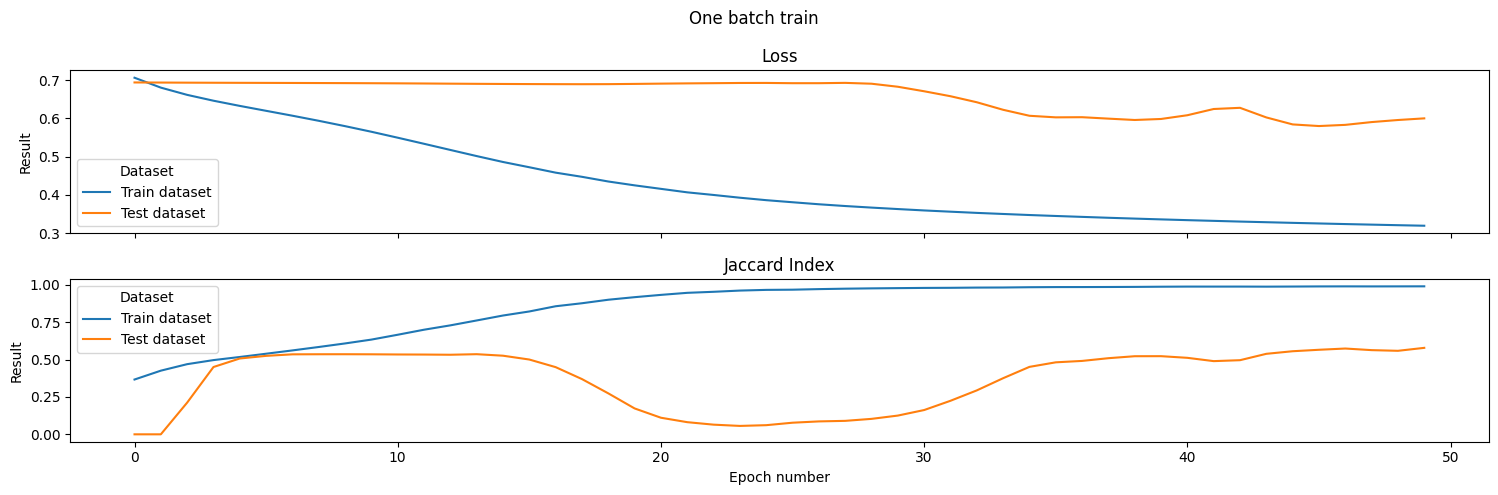

In [53]:
results = pd.read_csv("results-one-batch.csv")
plot_metrics(results, "One batch train")

In [54]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0             0             0  Train dataset           Loss  0.706215
1             1             0  Train dataset  Jaccard Index  0.366257
2             2             0   Test dataset           Loss  0.693884
3             3             0   Test dataset  Jaccard Index  0.000000
4             4             1  Train dataset           Loss  0.680346
..          ...           ...            ...            ...       ...
195         195            48   Test dataset  Jaccard Index  0.558179
196         196            49  Train dataset           Loss  0.319252
197         197            49  Train dataset  Jaccard Index  0.989202
198         198            49   Test dataset           Loss  0.599980
199         199            49   Test dataset  Jaccard Index  0.577944

[200 rows x 5 columns]

Train dataset result
Test dataset result


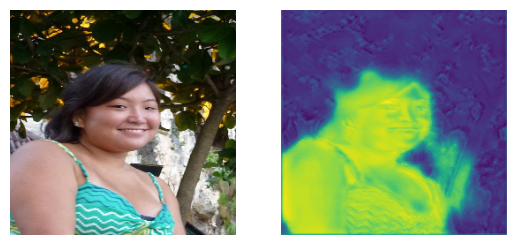

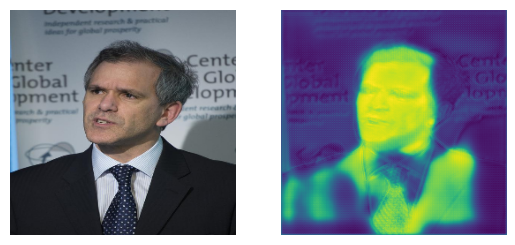

In [55]:
net.eval()

print("Train dataset result")
train_img, mask = train_dataset[0]
train_mask = net(train_img.cuda().unsqueeze(0))[0].cpu()
show_image_mask(train_img, nn.functional.sigmoid(train_mask))

print("Test dataset result")
test_img, mask = test_dataset[0]
test_mask = net(test_img.cuda().unsqueeze(0))[0].cpu() 
show_image_mask(test_img, nn.functional.sigmoid(test_mask))

По обучению на одном батче:
- Результат обучающей выборки превосходит результат тестовой, на которой маска выделила только часть.
- Для обучающей выборки с увеличением шагов уменьшается Loss и увеличивается Jaccard Index, в то время как для тестовой выборки Loss держится около значений 0.6-0.7, а Jacard Index начинает более менее стабильно увеличиваться c 30 эпох.

Обучим на всей выборке при 15 эпохах и размере батча 16.

In [56]:
batch_size = 16
epoch_number = 15
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [57]:
from torch.utils.data.datapipes.datapipe import UNTRACABLE_DATAFRAME_PIPES
net = UNET(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters())
criterion = nn.BCEWithLogitsLoss()

train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results-full-dataset.csv")

100%|██████████| 16/16 [00:03<00:00,  4.47it/s]


Визуализируем результаты.

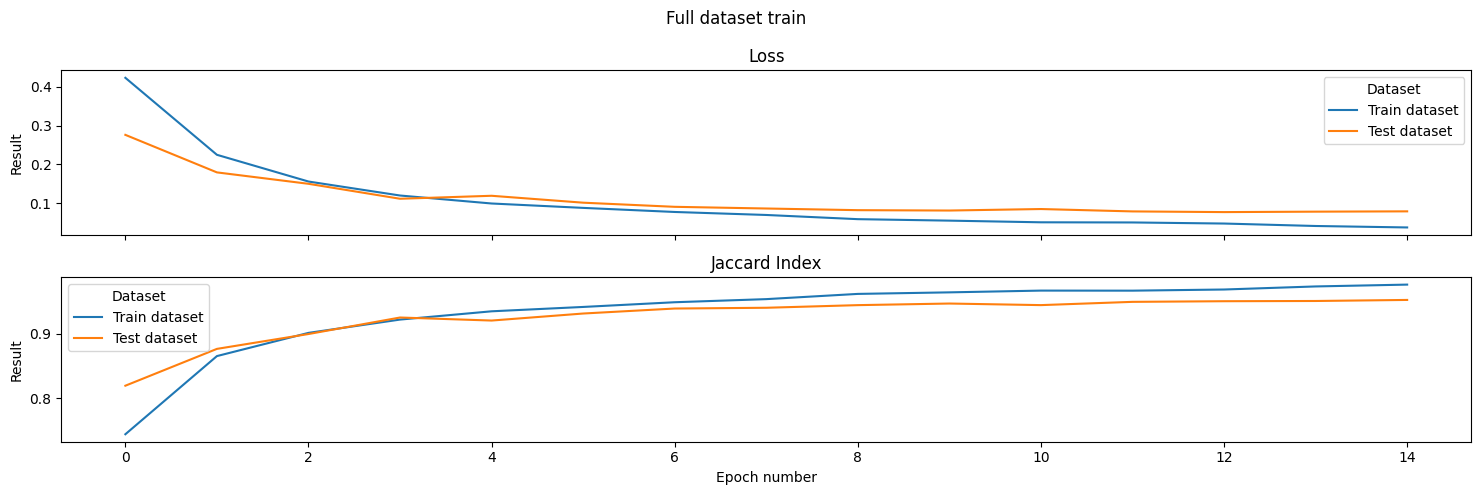

In [58]:
results = pd.read_csv("results-full-dataset.csv")
plot_metrics(results, "Full dataset train")

По графикам видно увеличение Jacard index и уменьшение Loss при увеличении числа шагов, при этом изменения становятся менее резкими после 4 эпох.

In [59]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.422739
1            1             0  Train dataset  Jaccard Index  0.744192
2            2             0   Test dataset           Loss  0.276165
3            3             0   Test dataset  Jaccard Index  0.819461
4            4             1  Train dataset           Loss  0.224922
5            5             1  Train dataset  Jaccard Index  0.865398
6            6             1   Test dataset           Loss  0.179722
7            7             1   Test dataset  Jaccard Index  0.876572
8            8             2  Train dataset           Loss  0.156245
9            9             2  Train dataset  Jaccard Index  0.901379
10          10             2   Test dataset           Loss  0.150394
11          11             2   Test dataset  Jaccard Index  0.899602
12          12             3  Train dataset           Loss  0.120301
13          13             3  Train dataset  Jaccard Index  0.922006
14          14             3   Test dataset           Loss  0.111973
15          15             3   Test dataset  Jaccard Index  0.925222
16          16             4  Train dataset           Loss  0.099794
17          17             4  Train dataset  Jaccard Index  0.934846
18          18             4   Test dataset           Loss  0.119626
19          19             4   Test dataset  Jaccard Index  0.920504
20          20             5  Train dataset           Loss  0.088519
21          21             5  Train dataset  Jaccard Index  0.941606
22          22             5   Test dataset           Loss  0.101877
23          23             5   Test dataset  Jaccard Index  0.931400
24          24             6  Train dataset           Loss  0.078012
25          25             6  Train dataset  Jaccard Index  0.948907
26          26             6   Test dataset           Loss  0.091261
27          27             6   Test dataset  Jaccard Index  0.939147
28          28             7  Train dataset           Loss  0.070314
29          29             7  Train dataset  Jaccard Index  0.953724
30          30             7   Test dataset           Loss  0.086925
31          31             7   Test dataset  Jaccard Index  0.940330
32          32             8  Train dataset           Loss  0.059535
33          33             8  Train dataset  Jaccard Index  0.961826
34          34             8   Test dataset           Loss  0.082651
35          35             8   Test dataset  Jaccard Index  0.944402
36          36             9  Train dataset           Loss  0.055755
37          37             9  Train dataset  Jaccard Index  0.964228
38          38             9   Test dataset           Loss  0.081717
39          39             9   Test dataset  Jaccard Index  0.946896
40          40            10  Train dataset           Loss  0.051477
41          41            10  Train dataset  Jaccard Index  0.966952
42          42            10   Test dataset           Loss  0.085564
43          43            10   Test dataset  Jaccard Index  0.944442
44          44            11  Train dataset           Loss  0.051080
45          45            11  Train dataset  Jaccard Index  0.966856
46          46            11   Test dataset           Loss  0.079458
47          47            11   Test dataset  Jaccard Index  0.949498
48          48            12  Train dataset           Loss  0.048288
49          49            12  Train dataset  Jaccard Index  0.968639
50          50            12   Test dataset           Loss  0.077687
51          51            12   Test dataset  Jaccard Index  0.950489
52          52            13  Train dataset           Loss  0.041990
53          53            13  Train dataset  Jaccard Index  0.973406
54          54            13   Test dataset           Loss  0.078823
55          55            13   Test dataset  Jaccard Index  0.950843
56          56            14  Train dataset           Loss  0.038248
57

Посмотрим на 7 худших предсказаний.

In [60]:
def display_topN_worst_predictions(net, number):    
    predictions = []
    for i, data in tqdm(enumerate(test_loader, 0)):
        x = data[0]
        y = data[1]
        pred = net(x.cuda())
        metric = compute_jaccard_metric(pred, y).item()
        predictions.append((metric, i))

    worst_predictions = sorted(predictions)[:number]
    for _, idx in worst_predictions:
        image, mask = test_dataset[idx]
        pred = net(image.cuda().unsqueeze(0))
        show_image_mask(image, pred[0].cpu())

16it [00:03,  4.70it/s]


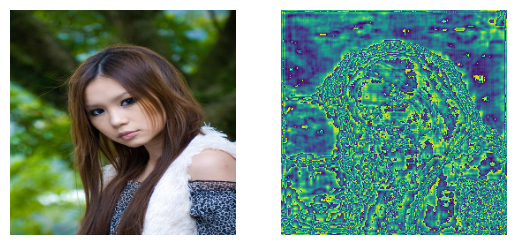

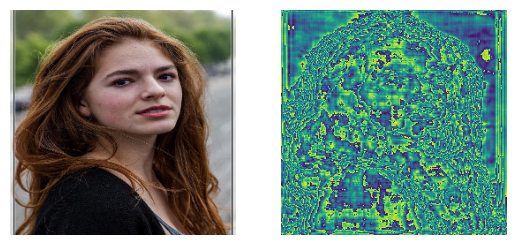

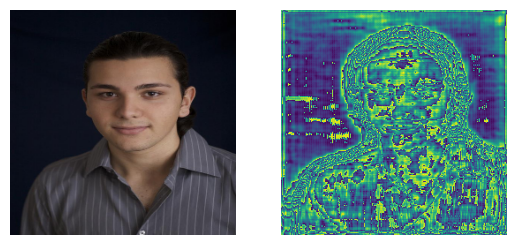

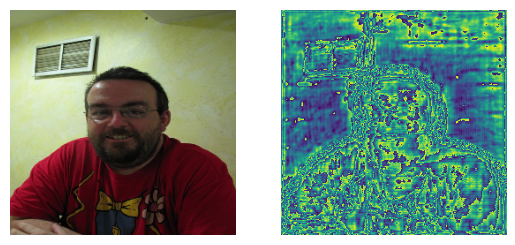

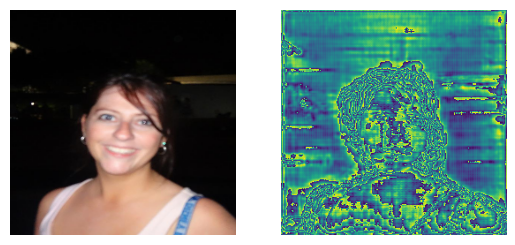

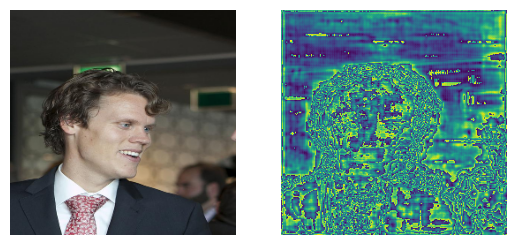

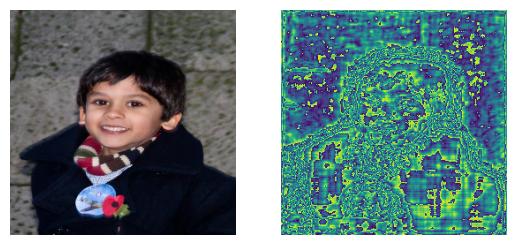

In [61]:
display_topN_worst_predictions(net, 7)

На худших результатах можно различить контур, однако его четкость, особенно на первом и втором предсказании, не лучшая.

### Попробовать улучшить качество не меняя архитектуру: аугментации, гиперпараметры. Сделать test time аугментации через horizontal flip, посмотреть улучшается ли что-то.

Увеличим датасет за счет дублирования изображений, но отраженных по горизонтали и изменением параметров изображения (color jitter).

In [62]:
import copy
from torchvision import transforms

transformations = torch.nn.Sequential(
    transforms.RandomHorizontalFlip(p=1),
    transforms.ColorJitter(brightness=.4, hue=.2)
)

train_dataset_augmented = copy.copy(train_dataset)
train_dataset_augmented.transform = transformations

train_dataset_extended = torch.utils.data.ConcatDataset(
    [train_dataset_augmented, copy.copy(train_dataset)]
)

train_loader_extended = torch.utils.data.DataLoader(train_dataset_extended, batch_size=batch_size)

(-0.5, 255.5, 255.5, -0.5)

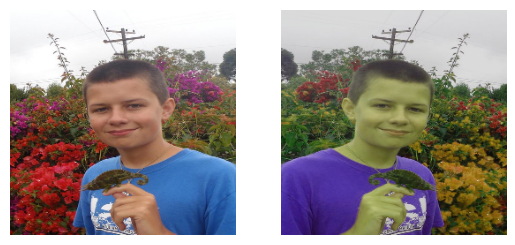

In [63]:
img_train, mask = train_dataset[19]
img_aug, mask = train_dataset_augmented[19]

_, (ax_l, ax_r) = plt.subplots(ncols=2)
ax_l.imshow(functional.to_pil_image(img_train))
ax_l.axis("off")
ax_r.imshow(functional.to_pil_image(img_aug))
ax_r.axis("off")

Обучим модель на увеличенном датасете.

In [64]:
train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-augmentation.csv")

100%|██████████| 16/16 [00:03<00:00,  4.40it/s]


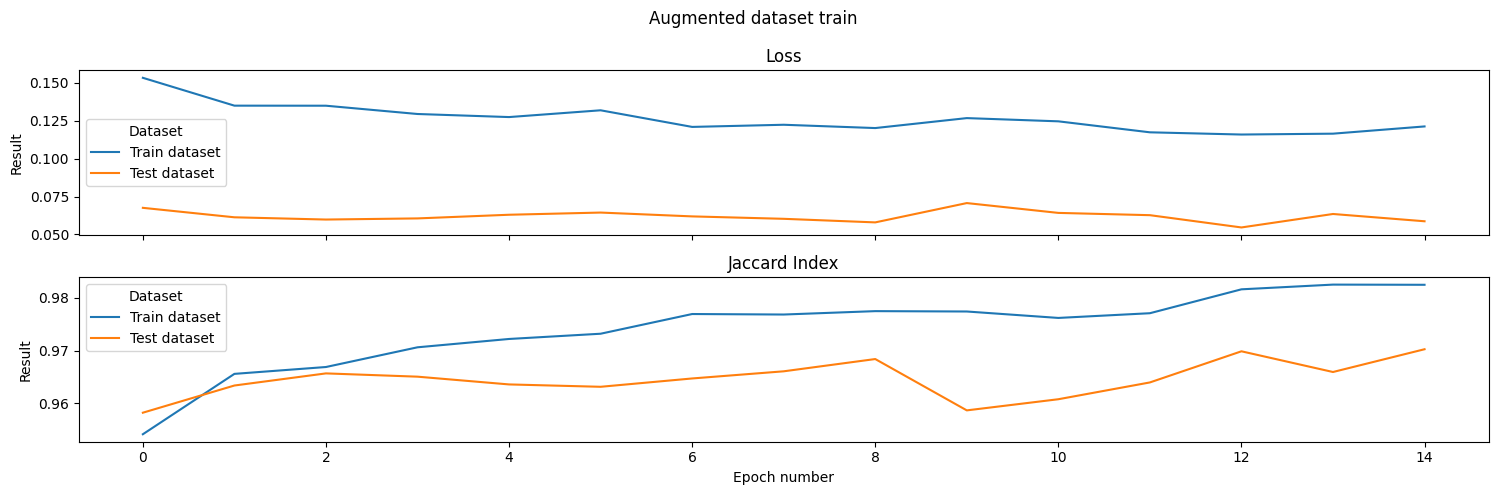

In [65]:
results = pd.read_csv("results-augmentation.csv")
plot_metrics(results, "Augmented dataset train")

По расширенному датасету:
- Loss как на обучающей, так и на тестовой выборке достиг значений Jaccard index > 0.96 и Loss < 0.15 за меньшее количество эпох, чем модель на исходном датасете; разброс значений меньше.
- Также увеличилось время обучения.

In [66]:
display(results)

Unnamed: 0  Epoch number        Dataset      Parameter    Result
0            0             0  Train dataset           Loss  0.153424
1            1             0  Train dataset  Jaccard Index  0.954188
2            2             0   Test dataset           Loss  0.067561
3            3             0   Test dataset  Jaccard Index  0.958259
4            4             1  Train dataset           Loss  0.135038
5            5             1  Train dataset  Jaccard Index  0.965598
6            6             1   Test dataset           Loss  0.061312
7            7             1   Test dataset  Jaccard Index  0.963397
8            8             2  Train dataset           Loss  0.135002
9            9             2  Train dataset  Jaccard Index  0.966894
10          10             2   Test dataset           Loss  0.059828
11          11             2   Test dataset  Jaccard Index  0.965688
12          12             3  Train dataset           Loss  0.129529
13          13             3  Train dataset  Jaccard Index  0.970619
14          14             3   Test dataset           Loss  0.060578
15          15             3   Test dataset  Jaccard Index  0.965068
16          16             4  Train dataset           Loss  0.127500
17          17             4  Train dataset  Jaccard Index  0.972194
18          18             4   Test dataset           Loss  0.062996
19          19             4   Test dataset  Jaccard Index  0.963603
20          20             5  Train dataset           Loss  0.131973
21          21             5  Train dataset  Jaccard Index  0.973184
22          22             5   Test dataset           Loss  0.064438
23          23             5   Test dataset  Jaccard Index  0.963156
24          24             6  Train dataset           Loss  0.121001
25          25             6  Train dataset  Jaccard Index  0.976908
26          26             6   Test dataset           Loss  0.061907
27          27             6   Test dataset  Jaccard Index  0.964730
28          28             7  Train dataset           Loss  0.122423
29          29             7  Train dataset  Jaccard Index  0.976814
30          30             7   Test dataset           Loss  0.060309
31          31             7   Test dataset  Jaccard Index  0.966082
32          32             8  Train dataset           Loss  0.120242
33          33             8  Train dataset  Jaccard Index  0.977454
34          34             8   Test dataset           Loss  0.057948
35          35             8   Test dataset  Jaccard Index  0.968400
36          36             9  Train dataset           Loss  0.126816
37          37             9  Train dataset  Jaccard Index  0.977386
38          38             9   Test dataset           Loss  0.070704
39          39             9   Test dataset  Jaccard Index  0.958698
40          40            10  Train dataset           Loss  0.124689
41          41            10  Train dataset  Jaccard Index  0.976170
42          42            10   Test dataset           Loss  0.064214
43          43            10   Test dataset  Jaccard Index  0.960804
44          44            11  Train dataset           Loss  0.117434
45          45            11  Train dataset  Jaccard Index  0.977060
46          46            11   Test dataset           Loss  0.062712
47          47            11   Test dataset  Jaccard Index  0.963979
48          48            12  Train dataset           Loss  0.115970
49          49            12  Train dataset  Jaccard Index  0.981577
50          50            12   Test dataset           Loss  0.054607
51          51            12   Test dataset  Jaccard Index  0.969863
52          52            13  Train dataset           Loss  0.116537
53          53            13  Train dataset  Jaccard Index  0.982468
54          54            13   Test dataset           Loss  0.063498
55          55            13   Test dataset  Jaccard Index  0.965950
56          56            14  Train dataset           Loss  0.121317
57

Посмотрим на 7 худших предсказаний.

16it [00:03,  4.80it/s]


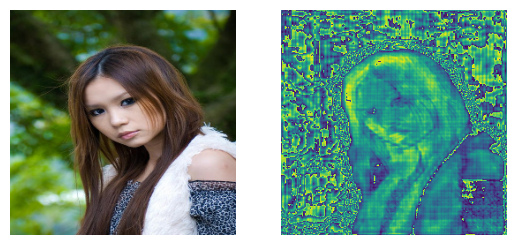

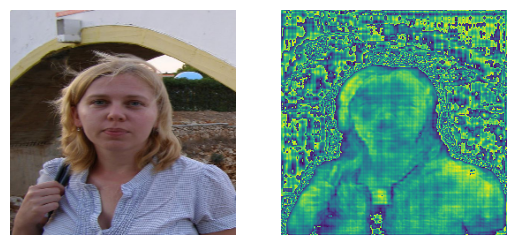

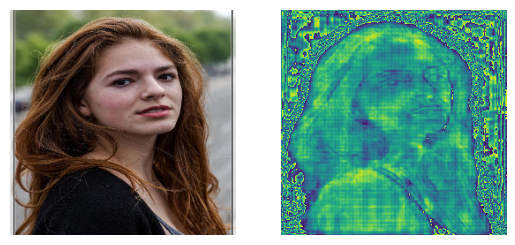

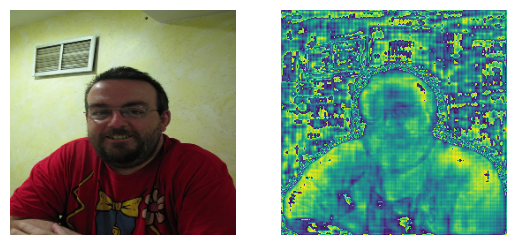

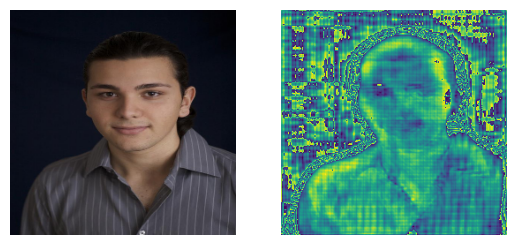

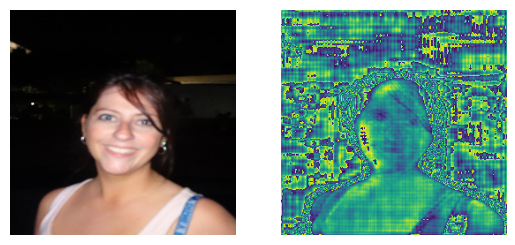

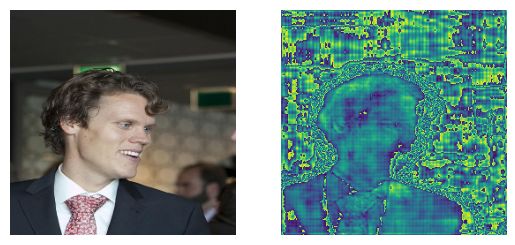

In [67]:
display_topN_worst_predictions(net, 7)

Среди худших предсказаний есть пересечения с предыдущими худшими, при этом контуры человека на всех предсказаниях выделены чётче.

Посмотрим что произойдет с качеством при использовании разных значений начальных значений числа каналов.

In [19]:
def train_with_channels(channels, train_loader, test_loader):
    net = UNET(3, channels, 1).cuda()
    optimizer = torch.optim.Adam(net.parameters())

    train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-channels-{channels}.csv")

In [20]:
channels = [4, 8, 16]
for channel in channels:
    print(f"Training channel={channel}")
    train_with_channels(channel, train_loader, test_loader)

Training channel=4


100%|██████████| 16/16 [00:02<00:00,  5.59it/s]


Training channel=8


100%|██████████| 16/16 [00:02<00:00,  5.40it/s]


Training channel=16


100%|██████████| 16/16 [00:03<00:00,  4.09it/s]


Построим графики.

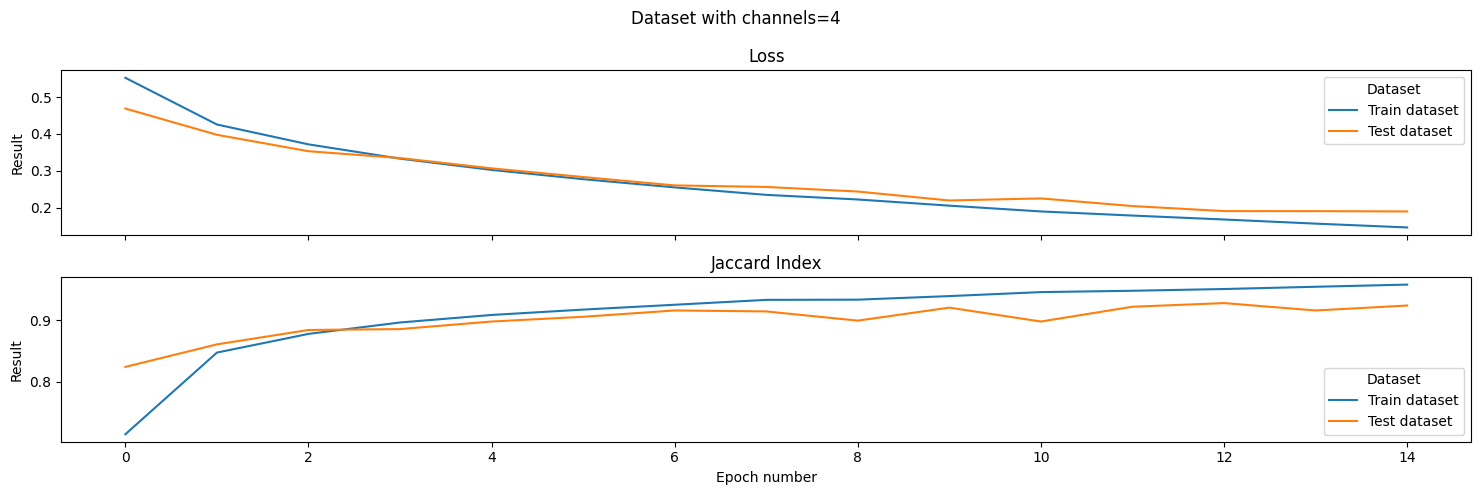

In [24]:
results = pd.read_csv("results-channels-4.csv")
plot_metrics(results, "Dataset with channels=4")

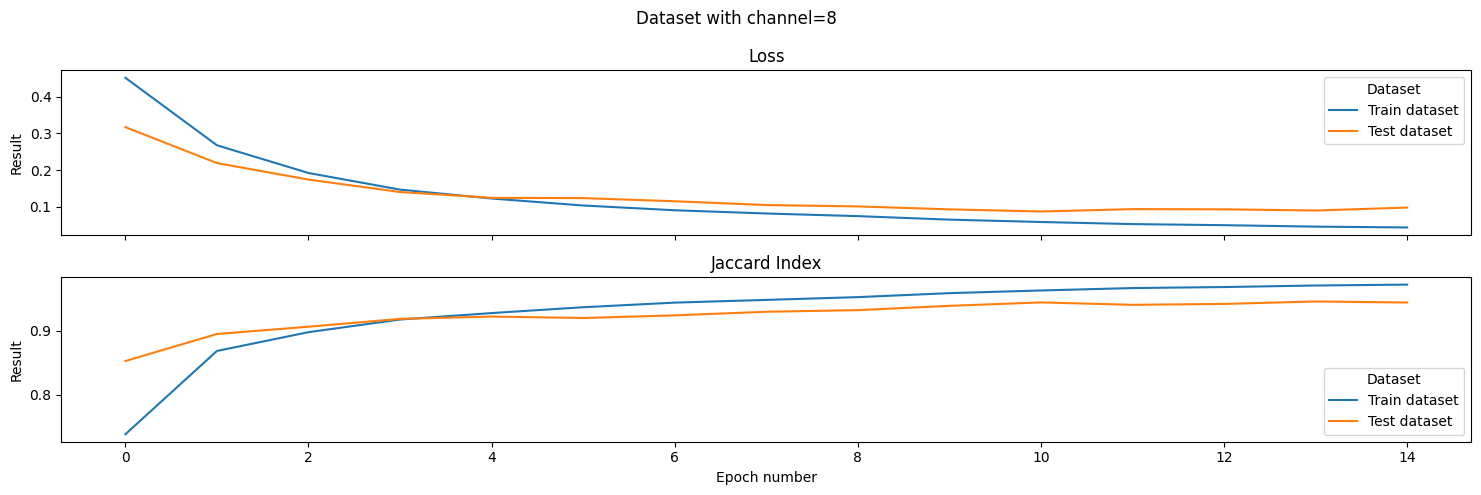

In [26]:
results = pd.read_csv("results-channels-8.csv")
plot_metrics(results, "Dataset with channel=8")

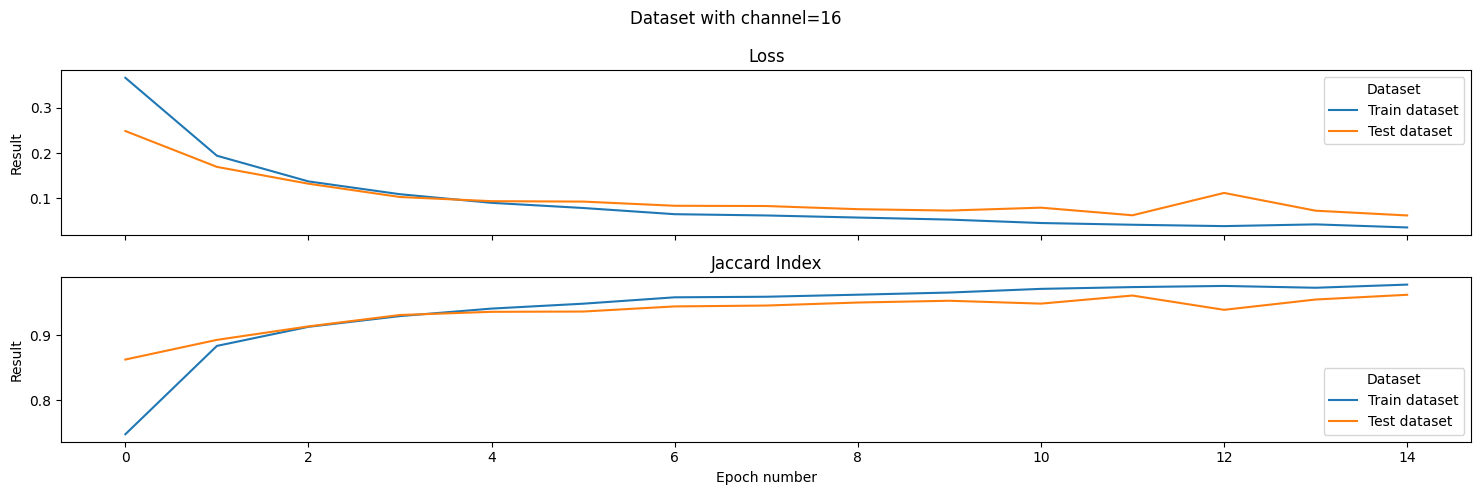

In [27]:
results = pd.read_csv("results-channels-16.csv")
plot_metrics(results, "Dataset with channel=16")

По графикам метрик с изменением значения начального количества каналов:
- С увеличением числа каналом значения начальные значения Loss меньше, при увеличении числа эпох они быстрее достигают 0.1 и далее прижимаются к нулю.
- Сходная история с Jaccard index, только начальные значения больше и они быстрее стремятся к 1.
- Для 4 каналов Jaccard index в пике был 0.95, для 8 - 0.97, для 16 - 0.96. Изменение начального количества каналов влияет на результаты сегментации, но незначительно.

Сделаем Test Time аугментацию через horizontal flip и посмотрим улучшится ли что-то.

In [28]:
class SegmentationTTAWrapper(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net

    def horizontal_flip(self, image):
        transformation = transforms.RandomHorizontalFlip(p=1)
        return transformation(image)

    def forward(self, image):
        flipped_image = self.horizontal_flip(image)
        concatenated_image = torch.cat([image, flipped_image])
        prediction = self.net(concatenated_image)

        result, augmented_result = prediction.chunk(2)
        flipped_augmented_result = self.horizontal_flip(augmented_result)

        return torch.mean(torch.stack([result, flipped_augmented_result]), dim=0)

In [29]:
net = UNET(3, 8, 1).cuda()
tta_net = SegmentationTTAWrapper(net).cuda()
optimizer = torch.optim.Adam(tta_net.parameters())

In [30]:
train_model(tta_net, optimizer, train_loader, test_loader, epoch_number).to_csv(f"results-tta.csv")

100%|██████████| 16/16 [00:03<00:00,  4.89it/s]


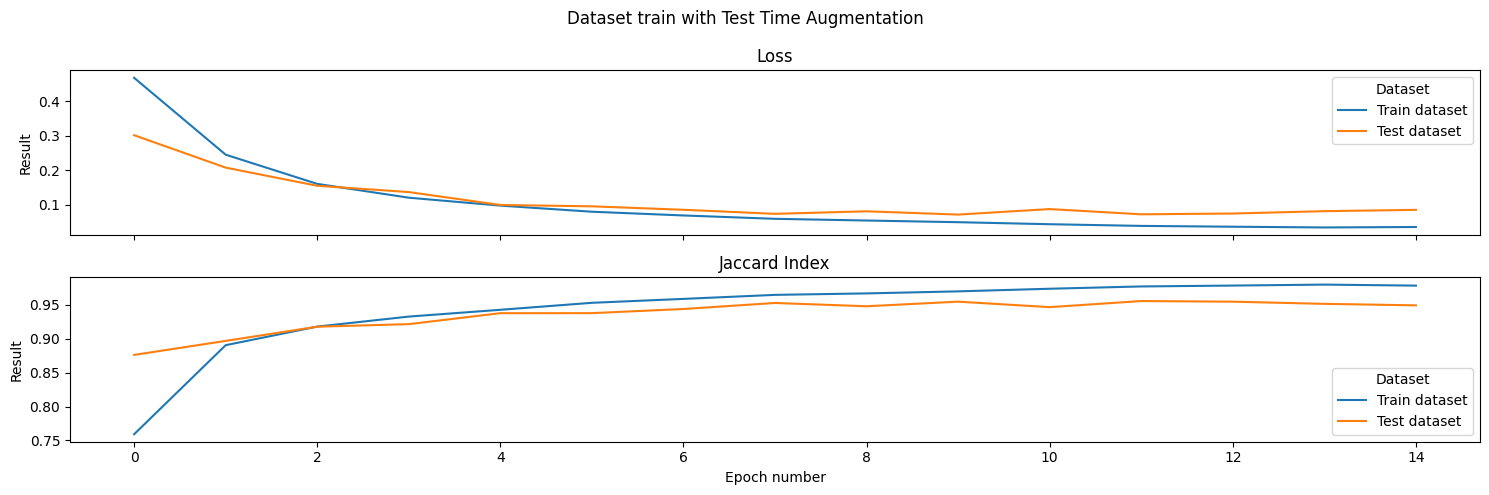

In [31]:
results = pd.read_csv("results-tta.csv")
plot_metrics(results, "Dataset train with Test Time Augmentation")

Обучение на расширенном датасете и TTA:
- Jaccard index: 0.97 и 0.95
- Loss: 0.12 и 0.03
- Обучение на расширенном датасете показало большее значениее Jaccard index, в то время как TTA - меньшее значение Loss.

### Попробовать улучшить качество изменяя архитектуру.

Введем skip connections между соответствующими слоями кодировщика и декодировщика.

In [32]:
from torch import nn

class CNNBlock2(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=0):
        super(CNNBlock2, self).__init__()

        self.seq_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.seq_block(x)


class CNNBlocks2(nn.Module):
    def __init__(self, n_conv, in_channels, out_channels, padding):
        super(CNNBlocks2, self).__init__()

        self.layers = nn.ModuleList()
        for i in range(n_conv):
            self.layers.append(CNNBlock2(in_channels, out_channels, padding=padding))
            in_channels = out_channels

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class Encoder2(nn.Module):
    def __init__(self, in_channels, out_channels, padding, n_down=4):
        super(Encoder2, self).__init__()

        self.enc_layers = nn.ModuleList()
        self.enc_connections = nn.ModuleList()
        for _ in range(n_down):
            self.enc_layers.append(CNNBlocks2(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))
            self.enc_connections.append(nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0))
            in_channels = out_channels
            out_channels *= 2

    def forward(self, x):
        connections = []
        for layer, connection in zip(self.enc_layers, self.enc_connections):
            x = layer(x)
            connections.append(x)
            x = connection(x)
        return x, connections


class Decoder2(nn.Module):
    def __init__(self, in_channels, out_channels, exit_channels, padding, n_up=4):
        super(Decoder2, self).__init__()

        self.exit_channels = exit_channels
        self.layers = nn.ModuleList()
        self.dec_connections = nn.ModuleList()
        self.dec_upsampling = nn.ModuleList()

        for i in range(n_up):
            self.layers.append(CNNBlocks2(n_conv=2, in_channels=in_channels, out_channels=out_channels, padding=padding))
            self.dec_connections.append(nn.Conv2d(out_channels, out_channels, kernel_size=1, stride=1, padding=0))
            self.dec_upsampling.append(nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2))
            in_channels //= 2
            out_channels //= 2

        self.exit_conv = nn.Conv2d(in_channels, self.exit_channels, kernel_size=1, padding=0)

    def forward(self, x, connections):
        for layer, connection, upsampling in zip(self.layers, self.dec_connections, self.dec_upsampling):
            x = upsampling(x)
            x = torch.cat([x, connections.pop()], dim=1)
            x = connection(x)
            x = layer(x)
        return self.exit_conv(x)


class UNET2(nn.Module):
    def __init__(self, in_channels, first_out_channels, exit_channels, n_down=4, padding=1):
        super(UNET2, self).__init__()
        self.encoder = Encoder(in_channels, first_out_channels, padding=padding, n_down=n_down)
        self.decoder = Decoder(first_out_channels * (2 ** n_down),
                               first_out_channels * (2 ** (n_down - 1)),
                               exit_channels, padding=padding, n_up=n_down)

    def forward(self, x):
        enc_out, connections = self.encoder(x)
        return self.decoder(enc_out, connections)

In [72]:
net = UNET2(3, 16, 1)
net = net.cuda()
optimizer = torch.optim.Adam(net.parameters())

In [73]:
train_model(net, optimizer, train_loader_extended, test_loader, epoch_number).to_csv("results-unet2.csv")

100%|██████████| 16/16 [00:03<00:00,  4.01it/s]


In [74]:
train_model(net, optimizer, train_loader, test_loader, epoch_number).to_csv("results-unet2-wo-aug.csv")

100%|██████████| 16/16 [00:03<00:00,  4.99it/s]


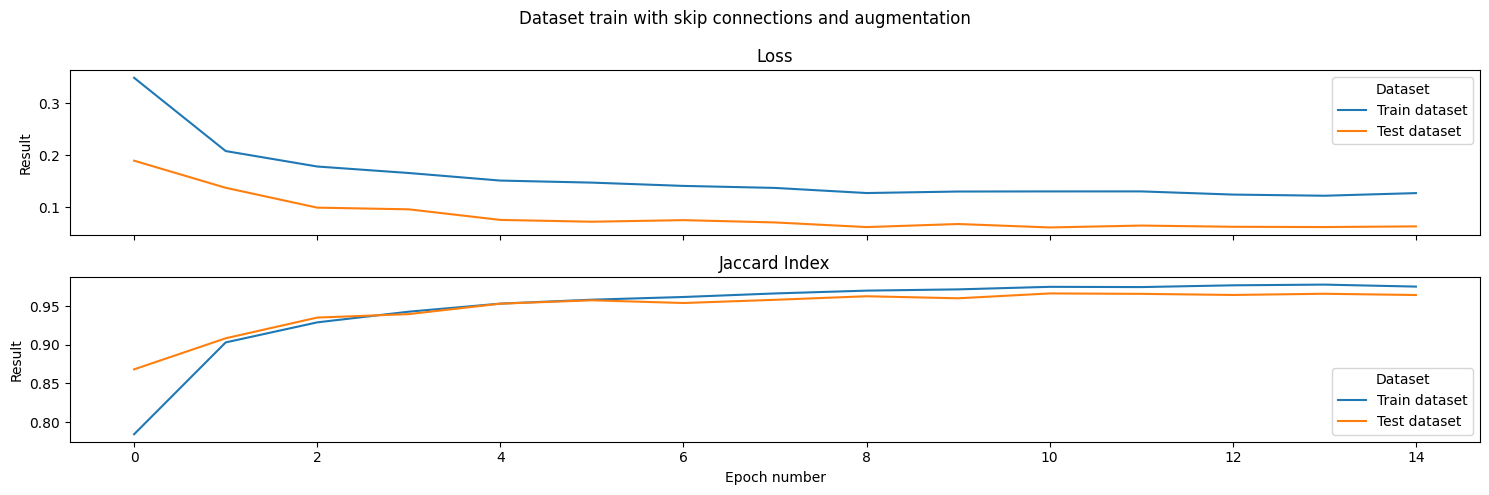

In [75]:
results = pd.read_csv("results-unet2.csv")
plot_metrics(results, "Dataset train with skip connections and augmentation")

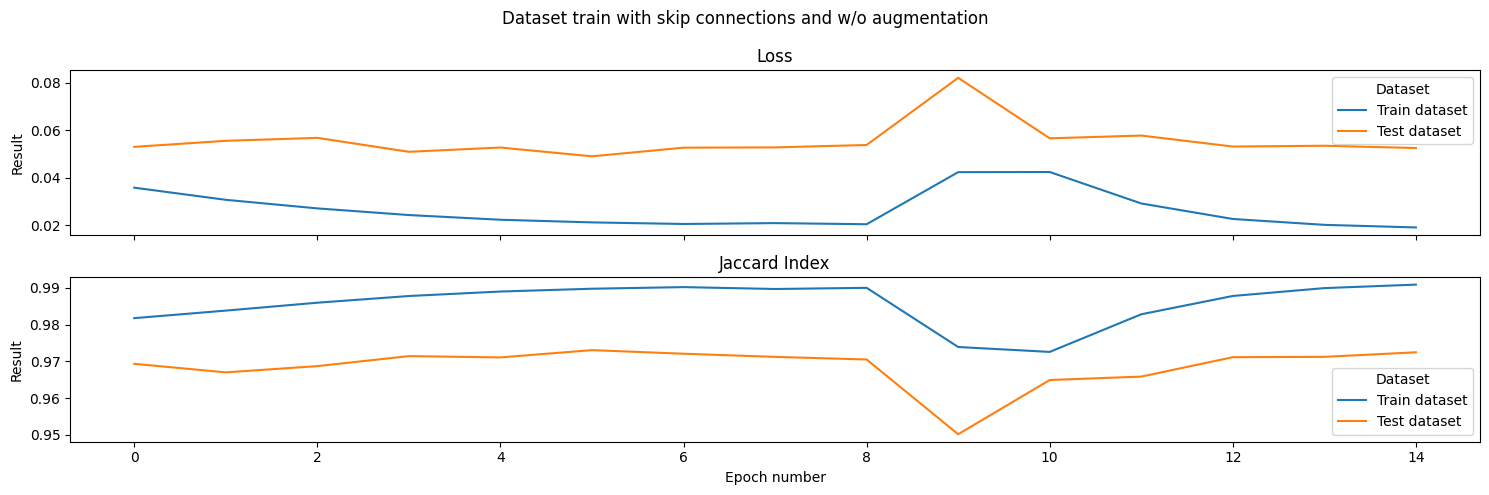

In [76]:
results = pd.read_csv("results-unet2-wo-aug.csv")
plot_metrics(results, "Dataset train with skip connections and w/o augmentation")

В этом варианте архитектуры улучшения результатов не получилось, значения Jaccard index и Loss сходны с предыдущими вариантами.

16it [00:04,  3.91it/s]


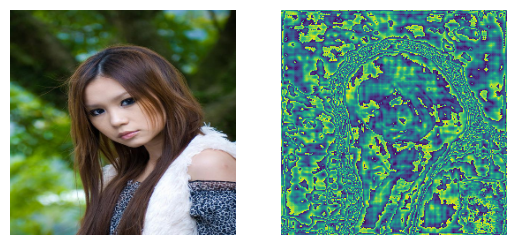

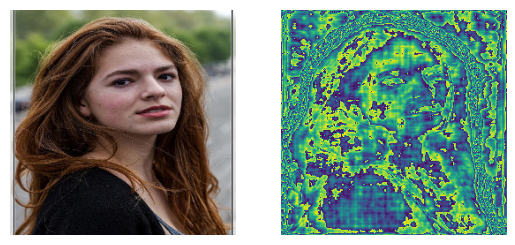

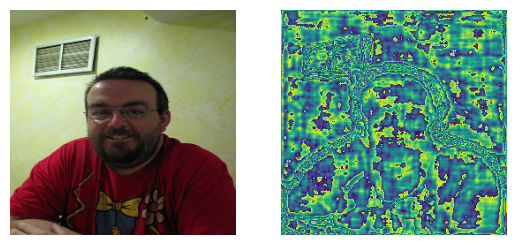

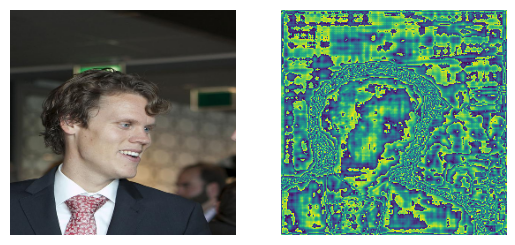

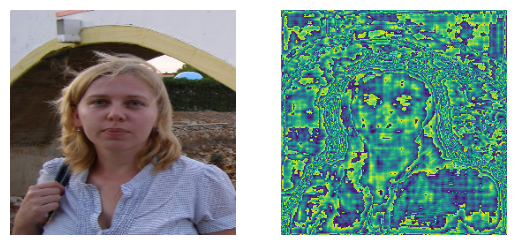

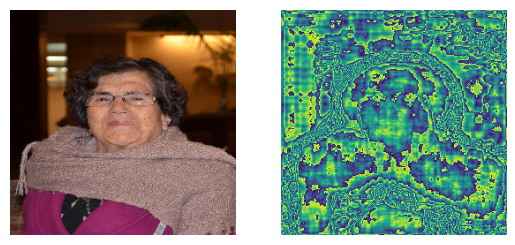

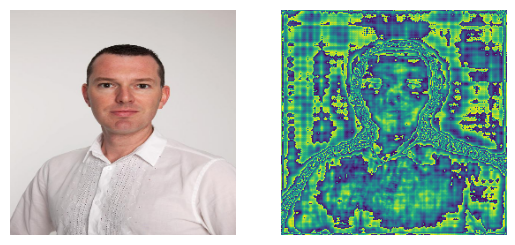

In [77]:
display_topN_worst_predictions(net, 7)

Топ худших предсказаний немного изменился - кроме "сложного" фона добавился однотонный белый фон, который оказался сложноотличим от белой рубашки.

### Итоги

- Переобучение на одном батче дало хорошие результаты на тренировочной части датасета, одновременно дав плохие на тестовой (Loss почти не падает, Jaccard index растет незначительно).
- Обучение на всем датасете улучшило результаты, дав Jaccard index > 0.94.
- Расширение датасета при помощи аугментации увеличило Jaccard index до 0.97, при этом значительно увеличилось время обучения.
- В опробованном варианте подбора гиперпараметров не было получено заметное улучшение метрик.
- Test Time аугментация не дала улучшения метрик.
- UNET с измененной архитектурой показала сходные с другими моделями результаты.